# **Import Libraries**

In [ ]:
#!pip install opendatasets

In [ ]:
#!pip install tensorflowjs

In [ ]:
import pandas as pd
import numpy as np
import os
import random
import shutil
from shutil import copyfile
from PIL import Image
#import opendatasets as od

#import tensorflowjs as tfjs
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from google.colab import files
import matplotlib.pyplot as plt

# **Download dan import datasets**

In [ ]:
#! chmod 600 /root/kaggle.json

In [ ]:
# Mendownload datasets dari kaggle
#od.download("https://www.kaggle.com/datasets/lavaman151/plantifydr-dataset")

In [ ]:
#sumber dataset
source_path = "/content/drive/MyDrive/dataset apple"

In [ ]:
#Buat direktori khusus
# Direktori lama yang berisi dataset Apel
old_directory = source_path 

# Nama direktori baru
new_directory = "/content/Apple"  

# Membuat direktori baru di luar direktori lama
os.mkdir(new_directory)

## Pisahkan direktori Apple

In [ ]:
file_list = os.listdir(old_directory)

# Menyalin file-file dari direktori lama ke direktori baru
for file_name in file_list:
  src = os.path.join(old_directory, file_name)
  dst = os.path.join(new_directory, file_name)
  shutil.copytree(src, dst)

In [ ]:
base_dir = "/content/Apple"

healthy_dir = os.path.join(base_dir, 'Healthy')
rust_dir = os.path.join(base_dir, 'Rust')
scab_dir = os.path.join(base_dir, 'Scab')

In [ ]:
directories = [healthy_dir, rust_dir, scab_dir]
file_lists = [[os.path.join(d, f) for f in os.listdir(d)] for d in directories]

for files in file_lists:
    print(len(files))

2080
2133
2160


In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

# **Split Data**










In [ ]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_files = []
val_files = []
test_files = []

for files in file_lists:
    random.shuffle(files)  # Shuffle the files in each directory
    num_train = int(len(files) * train_ratio)
    num_val = int(len(files) * val_ratio)
    
    train_files.append(files[:num_train])
    val_files.append(files[num_train:num_train+num_val])
    test_files.append(files[num_train+num_val:])
    
print(f'Total training files: {sum([len(files) for files in train_files])}')
print(f'Total validation files: {sum([len(files) for files in val_files])}')
print(f'Total test files: {sum([len(files) for files in test_files])}')

Total training files: 4461
Total validation files: 955
Total test files: 957


In [ ]:
train_dir = '/content/train'  # path folder baru untuk data train
val_dir = '/content/validation'  # path folder baru untuk data validation
test_dir = '/content/test'  # path folder baru untuk data test

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for files in train_files:
    label = os.path.basename(os.path.dirname(files[0]))  # ambil nama direktori sebagai label/nama folder
    label_dir = os.path.join(train_dir, label)
    os.makedirs(label_dir, exist_ok=True)
    for file in files:
        shutil.copy2(file, label_dir)

for files in val_files:
    label = os.path.basename(os.path.dirname(files[0]))  # ambil nama direktori sebagai label/nama folder
    label_dir = os.path.join(val_dir, label)
    os.makedirs(label_dir, exist_ok=True)
    for file in files:
        shutil.copy2(file, label_dir)

for files in test_files:
    label = os.path.basename(os.path.dirname(files[0]))  # ambil nama direktori sebagai label/nama folder
    label_dir = os.path.join(test_dir, label)
    os.makedirs(label_dir, exist_ok=True)
    for file in files:
        shutil.copy2(file, label_dir)

# **Visualisasi data**

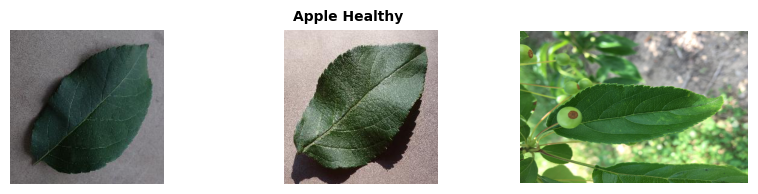

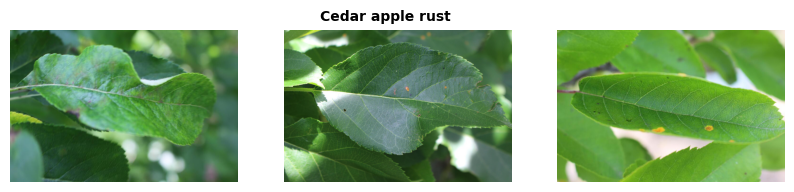

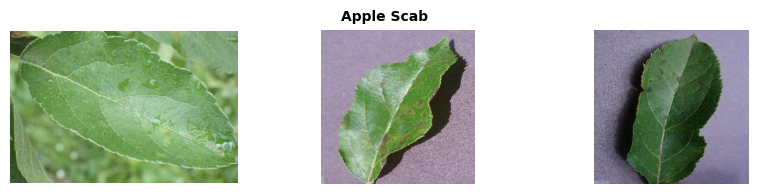

In [ ]:
labels = ['Apple Healthy' ,'Cedar apple rust','Apple Scab']

def display_images(train_dir, label, num_images=3):
    plt.figure(figsize=(10,2))
    plt.suptitle(label, fontsize=10, fontweight='bold')
    for i in range(num_images):
        image_path = os.path.join(base_dir, random.choice(os.listdir(base_dir)))
        image = plt.imread(image_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

# Display sample images from each directory
for i, base_dir in enumerate(directories):
    display_images(base_dir, labels[i])

# **Augmentasi Data**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255.)

# Load dataset from directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse')

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False)

Found 4461 images belonging to 3 classes.
Found 955 images belonging to 3 classes.
Found 957 images belonging to 3 classes.


In [ ]:
for image_batch, label_batch in train_generator:
  print(image_batch[0])
  break

[[[0.08648665 0.13354549 0.0551141 ]
  [0.0853374  0.13239622 0.05396485]
  [0.08418816 0.13124698 0.0528156 ]
  ...
  [0.5765746  0.7775555  0.3387113 ]
  [0.55531746 0.7631606  0.3141005 ]
  [0.55491924 0.75680995 0.31638077]]

 [[0.08563387 0.13953601 0.05426132]
  [0.08640004 0.13915294 0.05502749]
  [0.08716621 0.13876985 0.05579365]
  ...
  [0.59397626 0.7869641  0.37631384]
  [0.5704497  0.7722583  0.35235494]
  [0.5715154  0.76402545 0.33986914]]

 [[0.08610719 0.1449307  0.05473463]
  [0.08534101 0.14416455 0.05396847]
  [0.08457485 0.14339839 0.0532023 ]
  ...
  [0.6070731  0.7896375  0.3834421 ]
  [0.5793872  0.7779283  0.35798374]
  [0.58093023 0.7691377  0.34582788]]

 ...

 [[0.1036158  0.15407446 0.07450981]
  [0.10327534 0.16597632 0.08233089]
  [0.11651539 0.17982632 0.09597758]
  ...
  [0.3369891  0.39594552 0.22725162]
  [0.32202783 0.38846493 0.21603069]
  [0.31431764 0.35560578 0.20843528]]

 [[0.10434332 0.15371071 0.07450981]
  [0.10291157 0.1677951  0.08342217]


In [ ]:
categories = list(train_generator.class_indices.keys())
print(val_generator.class_indices)

{'Healthy': 0, 'Rust': 1, 'Scab': 2}


In [ ]:
import json
with open('class_indices.json','w') as f:
  json.dump(train_generator.class_indices, f)

from IPython.display import FileLink
FileLink(r'class_indices.json')

/content/class_indices.json

# **Latih model**

## MobileNet

In [ ]:
base_model = tf.keras.applications.MobileNetV2(weights = 'imagenet',
                                                include_top = False,
                                                input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3) 
                                                )

base_model.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
inputs = tf.keras.Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3))

x = base_model(inputs, training = False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(len(categories), activation="softmax")(x)

model_mobilenet = tf.keras.Model(inputs = inputs, 
                    outputs = x, 
                    name="AppleLeafDisease_MobileNetV2")

model_mobilenet.summary()

Model: "AppleLeafDisease_MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable para

In [ ]:
opt = Adam(learning_rate = 0.001)

model_mobilenet.compile(optimizer = opt,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics = ['accuracy'])

In [ ]:
hist_mobilenet = model_mobilenet.fit(train_generator,
                    validation_data = val_generator,
                    epochs = 15,
                    batch_size = BATCH_SIZE,
                    validation_steps = 29 # 955 = batch_size * steps
                    )

Epoch 1/15
140/140 [==============================] - 156s 1s/step - loss: 0.5806 - accuracy: 0.7642 - val_loss: 0.3902 - val_accuracy: 0.8599
Epoch 2/15
140/140 [==============================] - 135s 968ms/step - loss: 0.3904 - accuracy: 0.8453 - val_loss: 0.3037 - val_accuracy: 0.8836
Epoch 3/15
140/140 [==============================] - 142s 1s/step - loss: 0.3389 - accuracy: 0.8695 - val_loss: 0.3400 - val_accuracy: 0.8696
Epoch 4/15
140/140 [==============================] - 136s 971ms/step - loss: 0.3099 - accuracy: 0.8859 - val_loss: 0.2359 - val_accuracy: 0.9159
Epoch 5/15
140/140 [==============================] - 137s 977ms/step - loss: 0.3028 - accuracy: 0.8908 - val_loss: 0.2760 - val_accuracy: 0.8976
Epoch 6/15
140/140 [==============================] - 148s 1s/step - loss: 0.2940 - accuracy: 0.8933 - val_loss: 0.3016 - val_accuracy: 0.8815
Epoch 7/15
140/140 [==============================] - 136s 972ms/step - loss: 0.2726 - accuracy: 0.8955 - val_loss: 0.2623 - val_accu

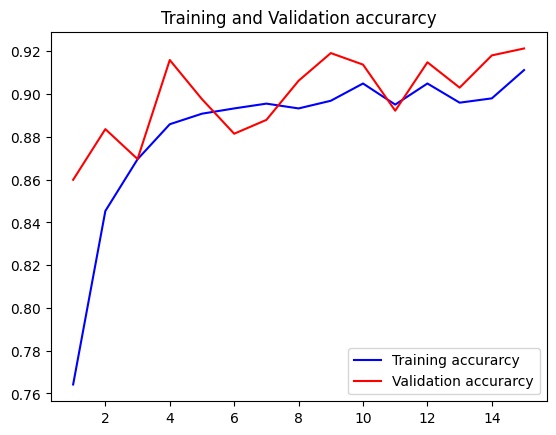

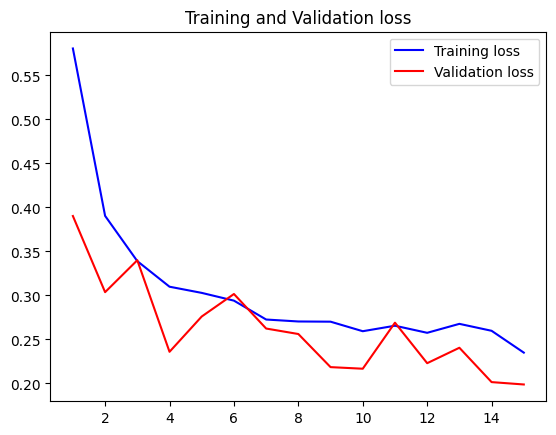

In [ ]:
acc = hist_mobilenet.history['accuracy']
val_acc = hist_mobilenet.history['val_accuracy']
loss = hist_mobilenet.history['loss']
val_loss = hist_mobilenet.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
#@title
loss, accuracy = model_mobilenet.evaluate(test_generator, verbose=1)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

30/30 [==============================] - 16s 523ms/step - loss: 0.2528 - accuracy: 0.8976
Test accuracy : 0.8975966572761536
Test loss : 0.25275829434394836


In [ ]:
#@title
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Prediksi menggunakan model
y_pred = model_mobilenet.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Ambil label sebenarnya dari generator
y_true = test_generator.classes

# Membuat confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Mendapatkan daftar nama kelas
class_names = list(test_generator.class_indices.keys())

# Membuat plot confusion matrix
plt.figure(figsize=(8, 6), dpi=100)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
#plt.savefig('confusion_matrix.png')
plt.show()

# Membuat classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

## VGG16

In [ ]:
base_model = tf.keras.applications.VGG16(weights = 'imagenet',
                                                include_top = False,
                                                input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3) 
                                                )

base_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3))

x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(len(categories), activation="softmax")(x)

model_vgg = tf.keras.Model(inputs = inputs, 
                    outputs = x, 
                    name="AppleLeafDisease_VGG16")

model_vgg.summary()

Model: "AppleLeafDisease_VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 14,716,227
Trainable params: 1,539
Non-trainable params: 14,714,688
____________________________

In [ ]:
opt = Adam(learning_rate=0.01)

model_vgg.compile(optimizer = opt,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics = ['accuracy'])

In [ ]:
#@title
checkpoint2 = ModelCheckpoint('apple_vgg.h5', monitor='val_loss',save_weights_only=True,
                             verbose=1, save_best_only=True, mode='auto')

In [ ]:
hist_vgg = model_vgg.fit(train_generator,
                    validation_data = val_generator,
                    epochs = 10,
                    batch_size = BATCH_SIZE,
                    validation_steps = 29, # 189 images = batch_size * steps
                    verbose=1
                    )

Epoch 1/10
140/140 [==============================] - 150s 1s/step - loss: 0.8025 - accuracy: 0.6429 - val_loss: 0.6492 - val_accuracy: 0.7317
Epoch 2/10
140/140 [==============================] - 148s 1s/step - loss: 0.7011 - accuracy: 0.7090 - val_loss: 0.5560 - val_accuracy: 0.7726
Epoch 3/10
140/140 [==============================] - 148s 1s/step - loss: 0.6828 - accuracy: 0.7149 - val_loss: 0.6698 - val_accuracy: 0.6918
Epoch 4/10
140/140 [==============================] - 143s 1s/step - loss: 0.6517 - accuracy: 0.7306 - val_loss: 0.6032 - val_accuracy: 0.7295
Epoch 5/10
140/140 [==============================] - 148s 1s/step - loss: 0.6655 - accuracy: 0.7270 - val_loss: 0.5222 - val_accuracy: 0.7769
Epoch 6/10
140/140 [==============================] - 148s 1s/step - loss: 0.6323 - accuracy: 0.7362 - val_loss: 0.5183 - val_accuracy: 0.8017
Epoch 7/10
140/140 [==============================] - 144s 1s/step - loss: 0.6355 - accuracy: 0.7357 - val_loss: 0.5073 - val_accuracy: 0.7909

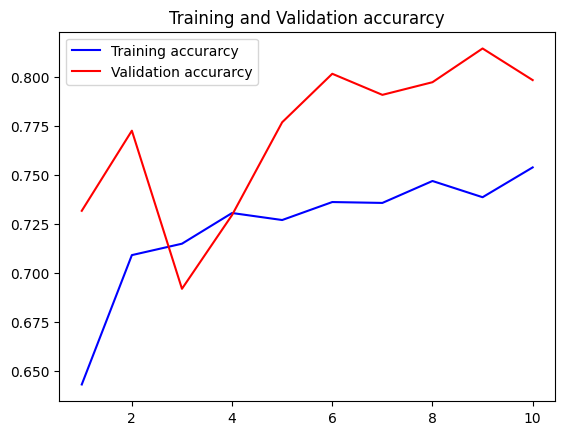

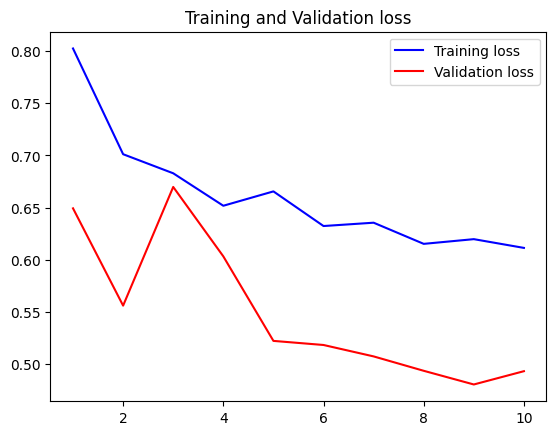

In [ ]:
acc = hist_vgg.history['accuracy']
val_acc = hist_vgg.history['val_accuracy']
loss = hist_vgg.history['loss']
val_loss = hist_vgg.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

## ResNet50

In [ ]:
resnet = tf.keras.applications.ResNet50V2(weights = 'imagenet',
                                                include_top = False,
                                                input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3) 
                                                )

resnet.trainable = False

94668760/94668760 [==============================] - 5s 0us/step


In [ ]:
inputs = tf.keras.Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3))

x = resnet(inputs)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(len(categories), activation="softmax")(x)

model_resnet = tf.keras.Model(inputs = inputs, 
                    outputs = x, 
                    name="AppleLeafDisease_ResNet50V2")
model_resnet.summary()

Model: "AppleLeafDisease_ResNet50V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 23,570,947
Trainable params: 6,147
Non-trainable params: 23,564,800
_______________________

In [ ]:
opt = Adam(learning_rate= 0.001)

model_resnet.compile(optimizer = opt,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
hist_resnet = model_resnet.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,
                    batch_size= BATCH_SIZE,
                    validation_steps= 29)

Epoch 1/10
140/140 [==============================] - 156s 1s/step - loss: 0.6671 - accuracy: 0.7151 - val_loss: 0.5009 - val_accuracy: 0.7974
Epoch 2/10
140/140 [==============================] - 144s 1s/step - loss: 0.4542 - accuracy: 0.8260 - val_loss: 0.4240 - val_accuracy: 0.8470
Epoch 3/10
140/140 [==============================] - 145s 1s/step - loss: 0.4129 - accuracy: 0.8458 - val_loss: 0.4193 - val_accuracy: 0.8373
Epoch 4/10
140/140 [==============================] - 145s 1s/step - loss: 0.3773 - accuracy: 0.8574 - val_loss: 0.3404 - val_accuracy: 0.8836
Epoch 5/10
140/140 [==============================] - 139s 990ms/step - loss: 0.3731 - accuracy: 0.8648 - val_loss: 0.3594 - val_accuracy: 0.8696
Epoch 6/10
140/140 [==============================] - 143s 1s/step - loss: 0.3538 - accuracy: 0.8673 - val_loss: 0.3337 - val_accuracy: 0.8772
Epoch 7/10
140/140 [==============================] - 143s 1s/step - loss: 0.3466 - accuracy: 0.8704 - val_loss: 0.3489 - val_accuracy: 0.8

## CNN

In [ ]:
model_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(len(categories), activation='softmax')
])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 128)      0

In [ ]:
opt = Adam(learning_rate=0.001)

model_cnn.compile(optimizer = opt,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics = ['accuracy'])

In [ ]:
#@title
checkpoint3 = ModelCheckpoint('apple_cnn.h5', monitor='val_loss',save_weights_only=True,
                             verbose=1, save_best_only=True, mode='auto')

In [ ]:
hist_cnn = model_cnn.fit(train_generator,
                    validation_data = val_generator,
                    epochs = 20,
                    batch_size = BATCH_SIZE,
                    validation_steps = 29,# images = batch_size * steps
                    verbose=1
                    )

Epoch 1/20
140/140 [==============================] - 171s 1s/step - loss: 0.9216 - accuracy: 0.5254 - val_loss: 0.7964 - val_accuracy: 0.5679
Epoch 2/20
140/140 [==============================] - 144s 1s/step - loss: 0.7850 - accuracy: 0.6028 - val_loss: 0.7984 - val_accuracy: 0.5841
Epoch 3/20
140/140 [==============================] - 143s 1s/step - loss: 0.7707 - accuracy: 0.6185 - val_loss: 0.7726 - val_accuracy: 0.6175
Epoch 4/20
140/140 [==============================] - 133s 951ms/step - loss: 0.7177 - accuracy: 0.6555 - val_loss: 0.5217 - val_accuracy: 0.8125
Epoch 5/20
140/140 [==============================] - 142s 1s/step - loss: 0.5041 - accuracy: 0.8021 - val_loss: 0.4332 - val_accuracy: 0.8341
Epoch 6/20
140/140 [==============================] - 140s 999ms/step - loss: 0.4291 - accuracy: 0.8341 - val_loss: 0.3153 - val_accuracy: 0.8804
Epoch 7/20
140/140 [==============================] - 140s 1s/step - loss: 0.3752 - accuracy: 0.8550 - val_loss: 0.2917 - val_accuracy: 

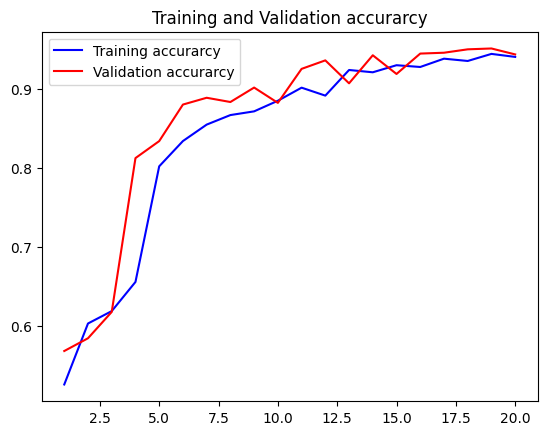

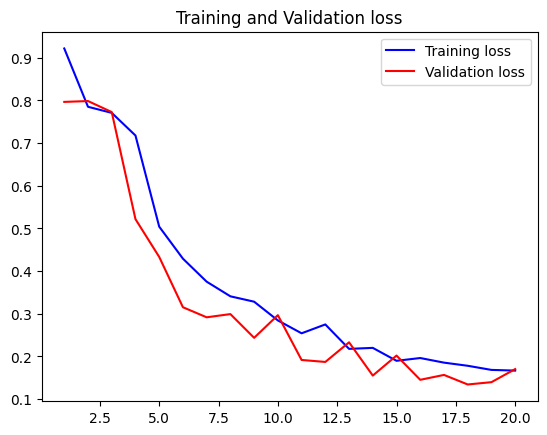

In [ ]:
acc = hist_cnn.history['accuracy']
val_acc = hist_cnn.history['val_accuracy']
loss = hist_cnn.history['loss']
val_loss = hist_cnn.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
loss_mobilenet, acc_mobilenet = model_mobilenet.evaluate(test_generator)
loss_vgg, acc_vgg = model_vgg.evaluate(test_generator)
loss_cnn ,acc_cnn = model_cnn.evaluate(test_generator)

print("Loss MobileNet: ", loss_mobilenet, "Accuracy MobineNet: ", acc_mobilenet)
print("Loss VGG16: ", loss_vgg, "Accuracy VGG16: ", acc_vgg)
print("Loss CNN: ", loss_cnn, "Accuracy CNN: ", acc_cnn)

24/24 [==============================] - 1s 22ms/step - loss: 0.0516 - accuracy: 0.9843
Loss MobileNet:  0.020384080708026886 Accuracy MobineNet:  0.9895287752151489
Loss VGG16:  0.3378905951976776 Accuracy VGG16:  0.9057591557502747
Loss CNN:  0.05157094821333885 Accuracy CNN:  0.9842932224273682


# **Classification Report**

In [ ]:
def create_classification_report(nama_model):
    y_pred = nama_model.predict(test_generator)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes

    cm = confusion_matrix(y_true, y_pred)
    class_names = list(test_generator.class_indices.keys())

    plt.figure(figsize=(8, 6), dpi=100)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

    report = classification_report(y_true, y_pred, target_names=class_names)
    print(report)

## MobilNet

30/30 [==============================] - 15s 501ms/step


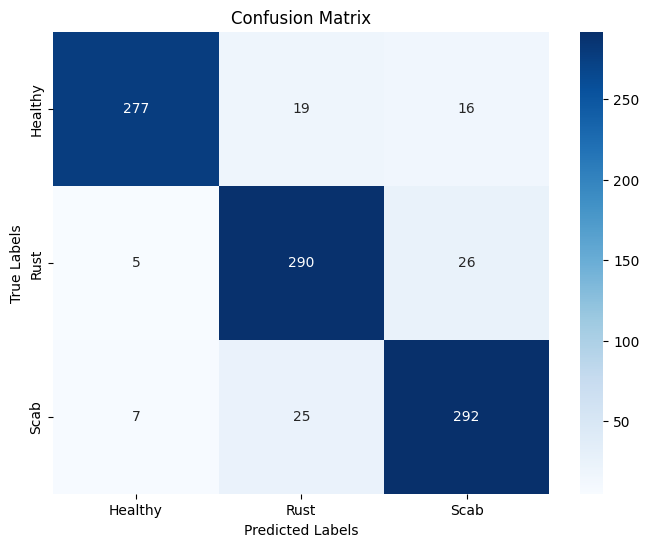

              precision    recall  f1-score   support

     Healthy       0.96      0.89      0.92       312
        Rust       0.87      0.90      0.89       321
        Scab       0.87      0.90      0.89       324

    accuracy                           0.90       957
   macro avg       0.90      0.90      0.90       957
weighted avg       0.90      0.90      0.90       957



In [ ]:
create_classification_report(model_mobilenet)

## VGG16

## ResNet50

30/30 [==============================] - 19s 620ms/step


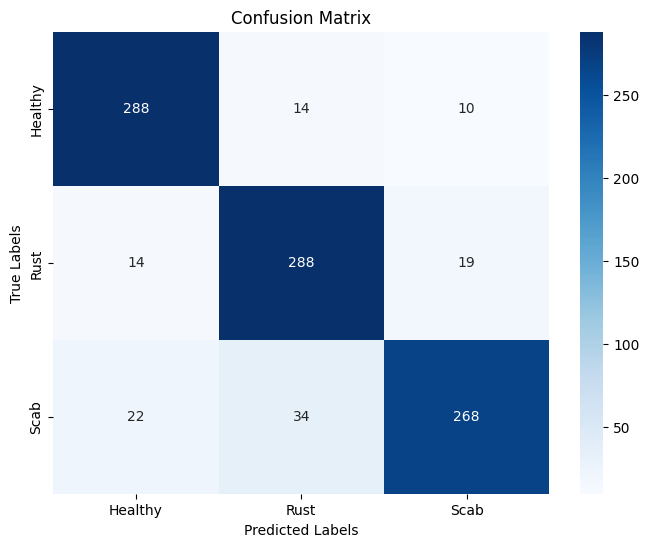

              precision    recall  f1-score   support

     Healthy       0.89      0.92      0.91       312
        Rust       0.86      0.90      0.88       321
        Scab       0.90      0.83      0.86       324

    accuracy                           0.88       957
   macro avg       0.88      0.88      0.88       957
weighted avg       0.88      0.88      0.88       957



In [ ]:
create_classification_report(model_resnet)

## CNN

30/30 [==============================] - 17s 595ms/step


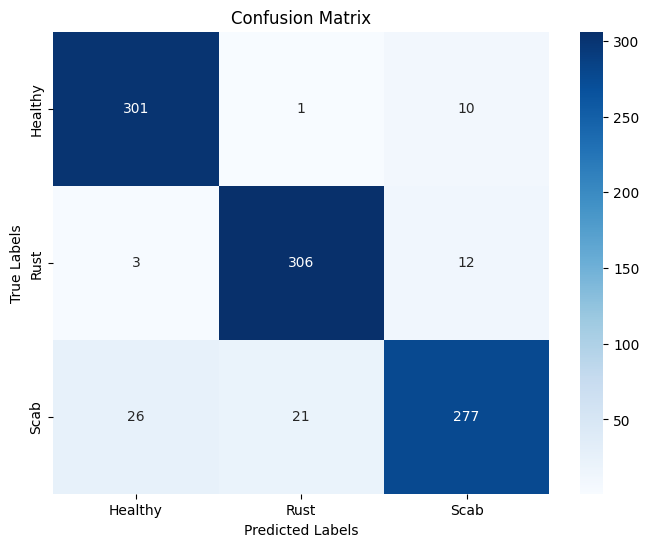

              precision    recall  f1-score   support

     Healthy       0.91      0.96      0.94       312
        Rust       0.93      0.95      0.94       321
        Scab       0.93      0.85      0.89       324

    accuracy                           0.92       957
   macro avg       0.92      0.92      0.92       957
weighted avg       0.92      0.92      0.92       957



In [ ]:
create_classification_report(model_cnn)

# Test Data baru

In [ ]:
#@title
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model_2.predict(images, batch_size=10)
  print(fn)
  print(classes)

In [ ]:
# Mengunggah gambar

uploaded = files.upload()

class_names = list(val_generator.class_indices.keys())

for fn in uploaded.keys():
  # Memuat gambar dan mengubah ukurannya
  path = fn
  image = np.array(Image.open(path).convert("RGB").resize((IMAGE_SIZE, IMAGE_SIZE)))
  image = image / 255
  img_array = tf.expand_dims(image, 0)

  # Prediksi gambar menggunakan model
  classes = model_mobilenet.predict(img_array)

  predicted_class_index = np.argmax(classes)
  predicted_class = class_names[predicted_class_index]
  confidence_level = classes[0][predicted_class_index] * 100

  print(fn)
  print("Gambar ini adalah", predicted_class)
  print("Confidence:", confidence_level, "%")

Saving applehealthyleaf0.jpeg to applehealthyleaf0 (1).jpeg
1/1 [==============================] - 0s 24ms/step
applehealthyleaf0.jpeg
Gambar ini adalah Healthy
Confidence: 72.73420691490173 %


# Save Model

In [ ]:
#model.save('/content/apple_model')

In [ ]:
#!zip -r /content/apple_model.zip /content/apple_model


In [ ]:
#files.download('/content/apple_model.zip')

In [ ]:
#framework = tf.version.VERSION
#print("Framework TensorFlow:", framework)

In [ ]:
model_mobilenet.save("content/apples.h5")

In [ ]:
import sys
print(sys.version)


3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]


In [ ]:
import PIL

print("Versi TensorFlow:", tf.__version__)
print("Versi Pillow:", PIL.__version__)
print("Versi Numpy", np.__version__)

Versi TensorFlow: 2.12.0
Versi Pillow: 8.4.0


In [ ]:
from google.cloud import storage

print("Versi Gcloud storage", storage.__version__)

Versi Gcloud storage 2.8.0
